In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import pandas as pd
import numpy as np
import geocoder

path = '/Users/216cjl/Local_Data/Datathon_Data/'
path_to_dataset = '/Users/216cjl/Local_Data/Datathon_Data/BigSupplyCo_Data_Files /'

customers = pd.read_csv(path_to_dataset + 'BigSupplyCo_Customers.csv')
orders = pd.read_csv(path_to_dataset + 'BigSupplyCo_Orders.csv')
products = pd.read_csv(path_to_dataset + 'BigSupplyCo_Products.csv')
departments = pd.read_csv(path_to_dataset + 'BigSupplyCo_Departments_Cleaned.csv')
categories = pd.read_csv(path_to_dataset + 'BigSupplyCo_Categories.csv')

customers['Customer Full Name'] = customers['Customer Fname'].astype(str)+ \
                                  ' ' + customers['Customer Lname'].astype(str)
customers['Customer Zipcode'] = customers['Customer Zipcode'].fillna(0)
customers = customers.drop(['Customer Email', 
                            'Customer Password',
                            'Customer Fname',
                            'Customer Lname',
                            'Customer Street'], axis=1)
                            #'Customer Zipcode'], axis=1) shall we drop this?
orders = orders.drop(['Order Zipcode',  # too few non-null values
                      'Order Item Discount',
#                       'Order Item Discount Rate',
                      'Sales',  # this and two above determine Order Item Total - after discounts
                      'Order Item Id',  # does not join with any other column in a different table
#                      'Order Item Quantity',  # I think the quantity is not important: perfection should occur for every order
                      'Unnamed: 0',
                      'Order Id'], axis=1) 
products = products.drop(['Product Description',  # NaN everywhere, hence remove it
                          'Product Image',  # useless, hence remove it 
                          'Product Status',  # only one value for this column, hence remove it
                          'Product Name'], axis=1)  # group by categories rather than by each of the same category

def get_country(row):
    return geocoder.osm([row['Latitude'], row['Longitude']], method='reverse').json['country']
# departments = departments.drop(['Latitude',
#                                 'Longitude'], axis=1)

join_dept = pd.merge(orders, departments, left_on='Order Department Id', right_on='Department Id').drop(
            columns=['Department Id'])
join_cust = pd.merge(join_dept, customers, left_on='Order Customer Id', right_on='Customer Id').drop(
            columns=['Customer Id'])
join_prod = pd.merge(join_cust, products, left_on='Order Item Cardprod Id', right_on='Product Card Id').drop(
            columns=['Product Card Id'])
data_ready = pd.merge(join_prod, categories, left_on='Product Category Id', right_on='Category Id').drop(
            columns=['Category Id'])

data_ready['Date'] = pd.to_datetime(data_ready['order date (DateOrders)'],
                                    infer_datetime_format=True).dt.date
data_ready.drop(columns=['order date (DateOrders)'], inplace=True)

data_ready['Date'] = pd.to_datetime(data_ready['Date'], infer_datetime_format=True).astype('datetime64[ns]')
data_ready.set_index('Date', inplace=True)
data_ready.sort_index(inplace=True)

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

#data_ready = reduce_mem_usage(data_ready)

def handle_non_numerical_data(df):
    columns = df.columns.values
    print(columns)
    for column in columns:
        text_digit_vals = {}
#         def convert_to_int(val):
#             return text_digit_vals[val]

        if df[column].dtype != np.int64 and df[column].dtype != np.float64:
            column_contents = df[column].values.tolist()
            unique_elements = set(column_contents)
            x = 0
            for unique in unique_elements:
                if unique not in text_digit_vals:
                    text_digit_vals[unique] = x
                    x+=1

#         df[column] = list(map(convert_to_int, df[column]))
    return df

df = data_ready.copy()
data_ready_only_numbers = handle_non_numerical_data(df)

print(data_ready.head(5))
print(data_ready_only_numbers.head(5))

['Order Item Cardprod Id' 'Order Customer Id' 'Order Department Id'
 'Market' 'Order City' 'Order Country' 'Order Region' 'Order State'
 'Order Status' 'Order Item Discount Rate' 'Order Item Quantity'
 'Order Item Total' 'Order Profit' 'Type' 'Days for shipping (real)'
 'Days for shipment (scheduled)' 'Delivery Status' 'Late Delivery Risk'
 'Department Name' 'Latitude' 'Longitude' 'Customer City'
 'Customer Country' 'Customer Segment' 'Customer State' 'Customer Zipcode'
 'Customer Full Name' 'Product Category Id' 'Product Price'
 'Category Name']
            Order Item Cardprod Id  Order Customer Id  Order Department Id  \
Date                                                                         
2015-01-01                     403               5225                    4   
2015-01-01                     134               1837                    2   
2015-01-01                     957               4189                    7   
2015-01-01                     365               1205    

In [45]:
customers = pd.read_csv(path_to_dataset + 'BigSupplyCo_Customers.csv')
orders = pd.read_csv(path_to_dataset + 'BigSupplyCo_Orders.csv')
products = pd.read_csv(path_to_dataset + 'BigSupplyCo_Products.csv')
departments = pd.read_csv(path_to_dataset + 'BigSupplyCo_Departments_Cleaned.csv')
categories = pd.read_csv(path_to_dataset + 'BigSupplyCo_Categories.csv')

customers['Customer Full Name'] = customers['Customer Fname'].astype(str)+ \
                                  ' ' + customers['Customer Lname'].astype(str)
customers['Customer Zipcode'] = customers['Customer Zipcode'].fillna(0)
customers = customers.drop(['Customer Email', 
                            'Customer Password',
                            'Customer Fname',
                            'Customer Lname',
                            'Customer Street'], axis=1)
                            #'Customer Zipcode'], axis=1) shall we drop this?
orders = orders.drop(['Order Zipcode',  # too few non-null values
                      'Order Item Discount',
#                       'Order Item Discount Rate',
                      'Sales',  # this and two above determine Order Item Total - after discounts
                      'Order Item Id',  # does not join with any other column in a different table
#                      'Order Item Quantity',  # I think the quantity is not important: perfection should occur for every order
                      'Unnamed: 0',
                      'Order Id'], axis=1) 
products = products.drop(['Product Description',  # NaN everywhere, hence remove it
                          'Product Image',  # useless, hence remove it 
                          'Product Status',  # only one value for this column, hence remove it
                          'Product Name'], axis=1)  # group by categories rather than by each of the same category

def get_country(row):
    return geocoder.osm([row['Latitude'], row['Longitude']], method='reverse').json['country']
# departments = departments.drop(['Latitude',
#                                 'Longitude'], axis=1)

join_dept = pd.merge(orders, departments, left_on='Order Department Id', right_on='Department Id').drop(
            columns=['Department Id'])
join_cust = pd.merge(join_dept, customers, left_on='Order Customer Id', right_on='Customer Id').drop(
            columns=['Customer Id'])
join_prod = pd.merge(join_cust, products, left_on='Order Item Cardprod Id', right_on='Product Card Id').drop(
            columns=['Product Card Id'])
data_raw = pd.merge(join_prod, categories, left_on='Product Category Id', right_on='Category Id').drop(
            columns=['Category Id'])



In [391]:
from adtk.detector import GeneralizedESDTestAD
esd_ad = GeneralizedESDTestAD(alpha=0.1)
anomalies = esd_ad.fit_detect(data_ready.groupby('Date')['Order Item Total'].sum())

In [392]:
total_sale = data_ready.groupby('Date')['Order Item Total'].sum()

In [394]:
anomalies = anomalies.reset_index()

In [395]:
anomalies['Month_Year'] = anomalies['Date'].dt.to_period('M')

In [396]:
a = anomalies.groupby('Month_Year').sum()

<AxesSubplot:xlabel='Month_Year'>

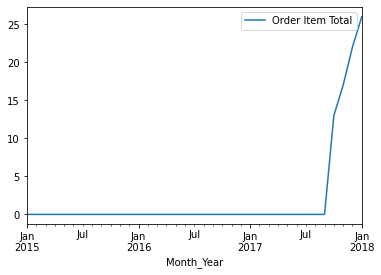

In [397]:
a.plot()

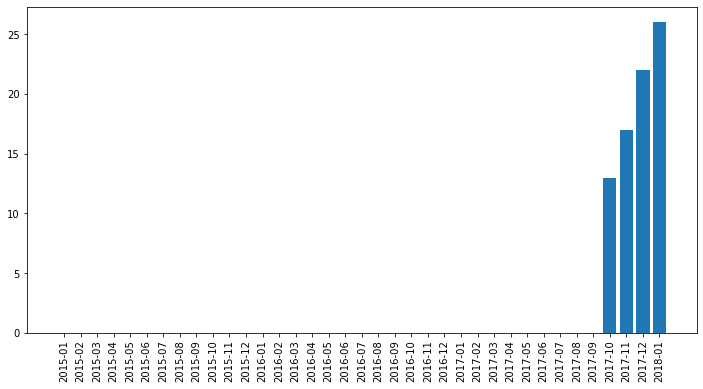

In [399]:
plt.subplots(figsize=(12,6))
plt.bar(range(len(a.index)), a.iloc[:,0], tick_label=list(a.index))
plt.xticks(rotation=90)
plt.savefig('anomaly_time.svg')
plt.show()

In [ ]:
data_ready['Month_Year'] = data_ready['Date'].dt.to_period('M')

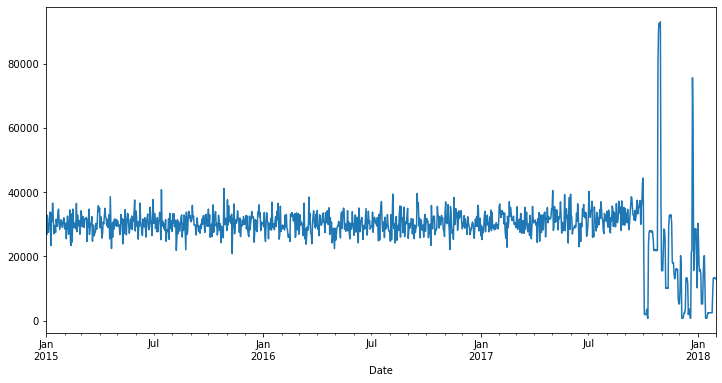

In [382]:
data_ready.groupby('Date')['Order Item Total'].sum().plot(figsize=(12,6))
plt.savefig('sale_time_series.svg')

In [442]:
eng = ['Colombia', 'Nicaragua', 'Honduras', 'Panama', 'Mexico', 'Brazil',
       'Dominican Republic', 'Cuba', 'Chile', 'Guatemala', 'Venezuela',
       'Argentina', 'Haiti', 'Peru', 'El Salvador', 'Bolivia', 'Uruguay',
       'Martinique', 'Paraguay', 'Jamaica', 'Costa Rica', 'Suriname',
       'Barbados', 'Ecuador', 'Trinidad and Tobago', 'Guadeloupe', 'Guyana',
       'French Guiana', 'Belize', 'Italy', 'France', 'Germany',
       'United Kingdom', 'Netherlands', 'Sweden', 'Spain', 'Austria',
       'Belgium', 'Portugal', 'Finland', 'Denmark', 'Norway',
       'Switzerland', 'Ireland', 'Cyprus', 'Luxembourg', 'Greece', 'Indonesia',
       'Vietnam', 'Australia', 'Philippines', 'China', 'India', 'Japan',
       'Cambodia', 'Malaysia', 'Thailand', 'Pakistan', 'South Korea',
       'Myanmar', 'Nepal', 'Afghanistan', 'Bangladesh',
       'Hong Kong', 'Singapore', 'Sri Lanka', 'Mongolia', 'Bhutan',
       'Taiwan', 'Papua New Guinea', 'Laos', 'New Zealand',
       'United States', 'Morocco', 'Cameroon', 'Poland', 'Russia',
       'Egypt', 'Israel', 'Ukraine', 'Saudi Arabia', 'Iran', 'Turkey',
       'Nigeria', 'South Africa', 'Democratic Republic of Congo',
       'Algeria', 'Ghana', 'Tunisia', 'Croatia', 'Romania', 'Togo', 'Sudan',
       'Canada', 'Iraq', 'Tanzania', 'Azerbaijan', 'Kenya', 'Lithuania',
       'Kazakhstan', 'Jordan', 'Mozambique', 'Yemen', 'Georgia',
       'Zambia', 'Somalia', 'Niger', 'Madagascar', 'Angola', 'Mauritania',
       'Ivory Coast', 'Liberia', 'Libya', 'Zimbabwe',
       'Czech Republic', 'Moldova', 'Qatar', 'Republic of Gambia',
       'Uzbekistan', 'Bosnia and Herzegovina', 'Kuwait', 'Bulgaria', 'Mali',
       'Senegal', 'Hungary', 'Namibia', 'Republic of Congo', 'Armenia',
       'Macedonia', 'Slovenia', 'Uganda', 'Turkmenistan', 'Benin',
       'Guinea', 'Syria', 'South Sudan', 'Belarus', 'Kyrgyzstan',
       'Central African Republic', 'Tajikistan', 'Rwanda', 'Slovakia',
       'Guinea-Bissau', 'Albania', 'Lesotho', 'Swaziland',
       'Burkina Faso', 'Montenegro', 'Oman', 'United Arab Emirates',
       'Gabon', 'Lebanon', 'Western Sahara', 'Botswana', 'Sierra Leone',
       'Estonia', 'Djibouti', 'Ethiopia', 'Equatorial Guinea', 'Bahrain',
       'Serbia', 'Chad', 'Burundi', 'Eritrea']

In [443]:
trans_dict = dict(zip(data_ready_cut['Order Country'].unique(), eng))

In [444]:
data_ready_cut['Order Country'] = data_ready_cut['Order Country'].map(trans_dict)

<ipython-input-444-a89ba0a66b2f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ready_cut['Order Country'] = data_ready_cut['Order Country'].map(trans_dict)


In [222]:
import statsmodels.stats.weightstats as st
from scipy import stats

In [215]:
numerical_feature = ['Order Item Discount Rate', 'Order Item Quantity', 'Order Item Total', 'Order Profit', 'Days for shipping (real)', 'Days for shipment (scheduled)', 'Late Delivery Risk',
                    'Product Price', 'Distance', 'Order_City_Count', 'FraudPrevNum', 'AbnormalFreq', 'OrderCount', 'DelayDays']


In [276]:
data_ready_num = data_ready_cut[numerical_feature]

In [297]:
def batch_ttest(data1, data2):
    li = []
    for fe in data1.columns:
        _, levene_P = stats.levene(data1[fe], data2[fe], center='mean')
        if levene_P > 0.05:
            a = ['Student T', data1[fe].mean(), data2[fe].mean()]
            li.append(tuple(a+list(stats.ttest_ind(data1[fe], data2[fe]))))
        else:
            a = ['Welch T', data1[fe].mean(), data2[fe].mean()]
            li.append(tuple(a+list(stats.ttest_ind(data1[fe], data2[fe], equal_var = False))))
    return pd.DataFrame(li, columns = ['Method', 'Fraud', 'NotFraud','T Statistic', 'P-value'], index = data1.columns)

In [298]:
t_result_num = batch_ttest(data_ready_num[data_ready_cut['Order Status'] == 'SUSPECTED_FRAUD'], data_ready_num[~(data_ready_cut['Order Status'] == 'SUSPECTED_FRAUD')])

In [529]:
t_result_num.to_csv('t_test.csv')

In [537]:
def batch_corrtest(y, data):
    li = []
    for fe in data.columns:
        li.append(stats.spearmanr(y, data[fe]))
    return pd.DataFrame(li, columns = ['Correlation', 'P-value'], index = data.columns)

In [538]:
corr_result_num = batch_corrtest(data_ready_cut['DelayDays'], data_ready_num)

In [539]:
corr_result_num

Correlation   P-value
Order Item Discount Rate          0.000991  0.685552
Order Item Quantity               0.000841  0.731307
Order Item Total                 -0.003604  0.141090
Order Profit                     -0.004077  0.095943
Days for shipping (real)          0.604635  0.000000
Days for shipment (scheduled)    -0.351150  0.000000
Late Delivery Risk                0.838828  0.000000
Product Price                    -0.003375  0.168155
Distance                          0.005956  0.014999
Order_City_Count                 -0.000418  0.864318
FraudPrevNum                      0.000570  0.815991
AbnormalFreq                     -0.005447  0.026112
OrderCount                       -0.000287  0.906581
DelayDays                         1.000000  0.000000

In [533]:
corr_result_num.to_csv('spearman.csv')

In [534]:
def batch_corrtest(y, data):
    li = []
    for fe in data.columns:
        li.append(stats.kendalltau(y, data[fe]))
    return pd.DataFrame(li, columns = ['Correlation', 'P-value'], index = data.columns)

In [535]:
corr_result_num = batch_corrtest(data_ready_cut['DelayDays'], data_ready_num)
corr_result_num

Correlation   P-value
Order Item Discount Rate          0.000741  0.685597
Order Item Quantity               0.000690  0.731264
Order Item Total                 -0.002628  0.141037
Order Profit                     -0.002967  0.096001
Days for shipping (real)          0.512979  0.000000
Days for shipment (scheduled)    -0.278556  0.000000
Late Delivery Risk                0.747852  0.000000
Product Price                    -0.002574  0.168214
Distance                          0.004352  0.014960
Order_City_Count                 -0.000331  0.863345
FraudPrevNum                      0.000508  0.815906
AbnormalFreq                     -0.004605  0.026089
OrderCount                       -0.000227  0.905991
DelayDays                         1.000000  0.000000

In [536]:
corr_result_num.to_csv('kendall.csv')

In [411]:
data_ready_cut['Delay'] = 0

<ipython-input-411-3c73bad72fbc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ready_cut['Delay'] = 0


In [416]:
data_ready_cut.loc[data_ready_cut['DelayDays']<0, 'Delay'] = 1

/Users/216cjl/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [419]:
contingency_table = pd.crosstab(
    data_ready_cut['Delay'],
    data_one_hot_cat['SUSPECTED_FRAUD'],
    margins = False
)

In [420]:
contingency_table

SUSPECTED_FRAUD       0     1
Delay                        
0                123819  2903
1                 39196   855

In [421]:
stats.chi2_contingency(contingency_table.values)

(3.29469501324439,
 0.0695040144313836,
 1,
 array([[123866.49415673,   2855.50584327],
        [ 39148.50584327,    902.49415673]]))

In [423]:
contingency_table = pd.crosstab(
    data_ready_cut['Delay'],
    data_ready_cut['Market'],
    margins = False
)

In [424]:
contingency_table

Market  Africa  Europe  LATAM  Pacific Asia   USCA
Delay                                             
0         8860   32037  39055         27102  19668
1         2754   10089  12539          8538   6131

In [425]:
stats.chi2_contingency(contingency_table.values)

(3.9835325307639007,
 0.40823906678329236,
 4,
 array([[ 8824.86558376, 32009.32388336, 39203.55733842, 27080.95483082,
         19603.29836364],
        [ 2789.13441624, 10116.67611664, 12390.44266158,  8559.04516918,
          6195.70163636]]))

In [520]:
contingency_table = pd.crosstab(
    data_ready_cut['Delay'],
    data_ready_cut['Order Country'],
    margins = False
)

In [521]:
contingency_table

Order Country  Afghanistan  Albania  Algeria  Angola  Argentina  Armenia  \
Delay                                                                      
0                      110       31      406     264       1408        5   
1                       26        6      110      42        523        0   

Order Country  Australia  Austria  Azerbaijan  Bahrain  Bangladesh  Barbados  \
Delay                                                                          
0                   5431      880          61        0         320        90   
1                   1642      281           7        4          80        27   

Order Country  Belarus  Belgium  Belize  Benin  Bhutan  Bolivia  \
Delay                                                             
0                  165      431       9     51       4      171   
1                   45      130       4     34       0       42   

Order Country  Bosnia and Herzegovina  Botswana  Brazil  Bulgaria  \
Delay                                                               
0                                  35        12    6066       133   
1                                  10         1    1921        33   

Order Country  Burkina Faso  Burundi  Cambodia  Cameroon  Canada  \
Delay                                                              
0                         6        0       105       198     668   
1                         5        1        21        77     291   

Order Country  Central African Republic  Chad  Chile  China  Colombia  \
Delay                                                                   
0                                    15     3    587   3528      1336   
1                                     8     0    151   1201       435   

Order Country  Costa Rica  Croatia  Cuba  ...  Slovenia  Somalia  \
Delay                                     ...                      
0                      31       69  2606  ...         6      107   
1                       5       17   928  ...         0       34   

Order Country  South Africa  South Korea  South Sudan  Spain  Sri Lanka  \
Delay                                                                     
0                       808          347            5   2462         11   
1                       291          107            0    748          0   

Order Country  Sudan  Suriname  Swaziland  Sweden  Switzerland  Syria  Taiwan  \
Delay                                                                           
0                176         0          5     589          207     50      14   
1                 75         8          0     174           41     13      13   

Order Country  Tajikistan  Tanzania  Thailand  Togo  Trinidad and Tobago  \
Delay                                                                      
0                       7       282       582    92                  122   
1                       0        96       174    30                   16   

Order Country  Tunisia  Turkey  Turkmenistan  Uganda  Ukraine  \
Delay                                                           
0                   32    2637            37      70      730   
1                    4     758            16      26      237   

Order Country  United Arab Emirates  United Kingdom  United States  Uruguay  \
Delay                                                                         
0                                24            4470          19000       98   
1                                 5            1534           5840       41   

Order Country  Uzbekistan  Venezuela  Vietnam  Western Sahara  Yemen  Zambia  \
Delay                                                                          
0                      98        727      467               2     55     215   
1                      23        257      170               0     16      51   

Order Country  Zimbabwe  
Delay                    
0                   146  
1                    44  

[2 rows x 164 columns]

In [522]:
stats.chi2_contingency(contingency_table.values)

(604.4379377636474,
 5.487628526960663e-52,
 163,
 array([[1.03339222e+02, 2.81143470e+01, 3.92081164e+02, 2.32513249e+02,
         1.46726498e+03, 3.79923609e+00, 5.37439937e+03, 8.82182619e+02,
         5.16696108e+01, 3.03938887e+00, 3.03938887e+02, 8.89021244e+01,
         1.59567916e+02, 4.26274289e+02, 9.87801383e+00, 6.45870135e+01,
         3.03938887e+00, 1.61847457e+02, 3.41931248e+01, 9.87801383e+00,
         6.06889973e+03, 1.26134638e+02, 8.35831939e+00, 7.59847217e-01,
         9.57407494e+01, 2.08957985e+02, 7.28693482e+02, 1.74764860e+01,
         2.27954165e+00, 5.60767246e+02, 3.59331749e+03, 1.34568942e+03,
         2.73544998e+01, 6.53468607e+01, 2.68530007e+03, 9.11816661e+00,
         1.42091430e+02, 7.67445690e+02, 1.70965624e+02, 2.35552637e+01,
         2.78787944e+03, 2.23395082e+02, 9.03458342e+02, 2.83119073e+03,
         1.51969443e+00, 1.51969443e+00, 2.20355693e+01, 1.89961804e+01,
         1.77804249e+02, 8.21318857e+03, 6.83862496e+00, 3.41931248e+01,
 

In [509]:
a = ((stats.chi2_contingency(contingency_table.values)[3][1]-contingency_table.iloc[1,:])/contingency_table.iloc[1,:]).replace([np.inf, -np.inf], np.nan).dropna()

In [527]:
np.log1p((a-min(a))/(max(a)-min(a))).to_csv('Delay_country_index.csv')

In [526]:
a.sort_values(ascending = False)

Order Country
Burundi              0.759847
Serbia               0.759847
Suriname             0.759847
Bahrain              0.759847
Macedonia            0.711817
                       ...   
Mongolia            -1.341490
Gabon               -1.701719
Botswana            -2.121986
Republic of Congo   -2.121986
Lesotho             -3.803056
Name: 1, Length: 147, dtype: float64

In [472]:
((stats.chi2_contingency(contingency_table.values)[3][1]-contingency_table.iloc[1,:])/contingency_table.iloc[1,:]).replace([np.inf, -np.inf], np.nan).dropna().to_csv('Delay_country_ratio.csv')


In [476]:
contingency_table = pd.crosstab(
    data_ready_cut['Delay'],
    data_ready_cut['Order Region'],
    margins = False
)

In [477]:
contingency_table

Order Region  Canada  Caribbean  Central Africa  Central America  \
Delay                                                              
0                668       6249            1318            21511   
1                291       2069             359             6830   

Order Region  Central Asia  East Africa  East of USA  Eastern Asia  \
Delay                                                                
0                      440         1430         5288          4450   
1                      113          422         1627          1514   

Order Region  Eastern Europe  North Africa  Northern Europe  Oceania  \
Delay                                                                  
0                       3007          2435             6047     6615   
1                        913           797             2013     2097   

Order Region  South America  South Asia  South of  USA   Southeast Asia  \
Delay                                                                     
0                     11295        5045            3070            5924   
1                      3640        1567             975            1866   

Order Region  Southern Africa  Southern Europe  US Center   West Africa  \
Delay                                                                     
0                         859             5885        4585         2818   
1                         298             1911        1302          878   

Order Region  West Asia  West of USA   Western Europe  
Delay                                                  
0                  4628          6057           17098  
1                  1381          1936            5252

In [478]:
stats.chi2_contingency(contingency_table.values)

(72.3232663734418,
 2.836387939150223e-07,
 22,
 array([[  728.69348156,  6320.40915496,  1274.26378371, 21534.82999047,
           420.19551126,  1407.23704676,  5254.34350884,  4531.72880502,
          2978.6010925 ,  2455.82620688,  6124.36857285,  6619.78895864,
         11348.31819299,  5024.10980195,  3073.58199469,  5919.20982413,
           879.14323062,  5923.76890744,  4473.22056928,  2808.39531579,
          4565.92192981,  6073.45880928, 16982.58531057],
        [  230.30651844,  1997.59084504,   402.73621629,  6806.17000953,
           132.80448874,   444.76295324,  1660.65649116,  1432.27119498,
           941.3989075 ,   776.17379312,  1935.63142715,  2092.21104136,
          3586.68180701,  1587.89019805,   971.41800531,  1870.79017587,
           277.85676938,  1872.23109256,  1413.77943072,   887.60468421,
          1443.07807019,  1919.54119072,  5367.41468943]]))

In [450]:
contingency_table = pd.crosstab(
    data_ready_cut['Delay'],
    data_ready_cut['Order Status'],
    margins = False
)

In [451]:
contingency_table

Order Status  CANCELED  CLOSED  COMPLETE  ON_HOLD  PAYMENT_REVIEW  PENDING  \
Delay                                                                        
0                 2584   13628     41805     6873            1357    14254   
1                  790    4436     13046     2272             389     4430   

Order Status  PENDING_PAYMENT  PROCESSING  SUSPECTED_FRAUD  
Delay                                                       
0                       27982       15336             2903  
1                        8879        4954              855

In [452]:
stats.chi2_contingency(contingency_table.values)

(17.63624825577013,
 0.024125190856000126,
 8,
 array([[ 2563.72451176, 13725.88013647, 41678.37972573,  6948.80280381,
          1326.69324171, 14196.98541131, 28008.72828336, 15417.30004257,
          2855.50584327],
        [  810.27548824,  4338.11986353, 13172.62027427,  2196.19719619,
           419.30675829,  4487.01458869,  8852.27171664,  4872.69995743,
           902.49415673]]))

In [486]:
contingency_table = pd.crosstab(
    data_one_hot_cat['SUSPECTED_FRAUD'],
    data_ready_cut['Market'],
    margins = False
)

In [487]:
contingency_table

Market           Africa  Europe  LATAM  Pacific Asia   USCA
SUSPECTED_FRAUD                                            
0                 11377   41138  50412         34891  25197
1                   237     988   1182           749    602

In [488]:
stats.chi2_contingency(contingency_table.values)

(8.81436279754012,
 0.06591076876950312,
 4,
 array([[11352.29449611, 41176.74857441, 50431.40022666, 34836.90165674,
         25217.65504608],
        [  261.70550389,   949.25142559,  1162.59977334,   803.09834326,
           581.34495392]]))

In [479]:
contingency_table = pd.crosstab(
    data_one_hot_cat['SUSPECTED_FRAUD'],
    data_ready_cut['Order Region'],
    margins = False
)

In [480]:
contingency_table

Order Region     Canada  Caribbean  Central Africa  Central America  \
SUSPECTED_FRAUD                                                       
0                   930       8128            1649            27710   
1                    29        190              28              631   

Order Region     Central Asia  East Africa  East of USA  Eastern Asia  \
SUSPECTED_FRAUD                                                         
0                         547         1821         6765          5840   
1                           6           31          150           124   

Order Region     Eastern Europe  North Africa  Northern Europe  Oceania  \
SUSPECTED_FRAUD                                                           
0                          3846          3157             7912     8519   
1                            74            75              148      193   

Order Region     South America  South Asia  South of  USA   Southeast Asia  \
SUSPECTED_FRAUD                                                              
0                        14574        6484            3979            7639   
1                          361         128              66             151   

Order Region     Southern Africa  Southern Europe  US Center   West Africa  \
SUSPECTED_FRAUD                                                              
0                           1125             7603        5766         3625   
1                             32              193         121           71   

Order Region     West Asia  West of USA   Western Europe  
SUSPECTED_FRAUD                                           
0                     5862          7757           21777  
1                      147           236             573

In [481]:
stats.chi2_contingency(contingency_table.values)

(71.48950554102942,
 3.8478809095566794e-07,
 22,
 array([[9.37390255e+02, 8.13056532e+03, 1.63921111e+03, 2.77023746e+04,
         5.40538906e+02, 1.81026773e+03, 6.75917999e+03, 5.82960947e+03,
         3.83166820e+03, 3.15917133e+03, 7.87837899e+03, 8.51568707e+03,
         1.45984603e+04, 6.46300768e+03, 3.95385149e+03, 7.61446307e+03,
         1.13092860e+03, 7.62032787e+03, 5.75434456e+03, 3.61271573e+03,
         5.87359546e+03, 7.81288875e+03, 2.18463735e+04],
        [2.16097450e+01, 1.87434681e+02, 3.77888867e+01, 6.38625425e+02,
         1.24610938e+01, 4.17322708e+01, 1.55820007e+02, 1.34390531e+02,
         8.83318043e+01, 7.28286713e+01, 1.81621006e+02, 1.96312928e+02,
         3.36539668e+02, 1.48992319e+02, 9.11485073e+01, 1.75536927e+02,
         2.60714024e+01, 1.75672129e+02, 1.32655442e+02, 8.32842726e+01,
         1.35404544e+02, 1.80111253e+02, 5.03626486e+02]]))

In [483]:
stats.chi2_contingency(contingency_table.values)[3][1]

array([ 21.60974498, 187.43468067,  37.78888669, 638.62542498,
        12.46109382,  41.73227081, 155.82000684, 134.39053084,
        88.33180431,  72.82867131, 181.6210058 , 196.31292835,
       336.53966769, 148.9923189 ,  91.14850725, 175.53692744,
        26.07140245, 175.67212918, 132.65544183,  83.28427263,
       135.4045439 , 180.11125302, 503.6264863 ])

In [485]:
((contingency_table.iloc[1,:] - stats.chi2_contingency(contingency_table.values)[3][1])/contingency_table.iloc[1,:]).replace([
    np.inf, -np.inf], np.nan).dropna().to_csv('Fraud_region_index.csv')

Order Region
Canada             0.254836
Caribbean          0.013502
Central Africa    -0.349603
Central America   -0.012085
Central Asia      -1.076849
East Africa       -0.346202
East of USA       -0.038800
Eastern Asia      -0.083795
Eastern Europe    -0.193673
North Africa       0.028951
Northern Europe   -0.227169
Oceania           -0.017165
South America      0.067757
South Asia        -0.164002
South of  USA     -0.381038
Southeast Asia    -0.162496
Southern Africa    0.185269
Southern Europe    0.089782
US Center         -0.096326
West Africa       -0.173018
West Asia          0.078881
West of USA        0.236817
Western Europe     0.121071
Name: 1, dtype: float64

In [489]:
((contingency_table.iloc[1,:] - stats.chi2_contingency(contingency_table.values)[3][1])/contingency_table.iloc[1,:]).replace([
    np.inf, -np.inf], np.nan).dropna().to_csv('Fraud_market_index.csv')

In [499]:
contingency_table = pd.crosstab(
    data_one_hot_cat['SUSPECTED_FRAUD'],
    data_ready_cut['Order Country'],
    margins = False
)

In [500]:
contingency_table

Order Country    Afghanistan  Albania  Algeria  Angola  Argentina  Armenia  \
SUSPECTED_FRAUD                                                              
0                        131       37      504     300       1892        5   
1                          5        0       12       6         39        0   

Order Country    Australia  Austria  Azerbaijan  Bahrain  Bangladesh  \
SUSPECTED_FRAUD                                                        
0                     6912     1130          68        4         399   
1                      161       31           0        0           1   

Order Country    Barbados  Belarus  Belgium  Belize  Benin  Bhutan  Bolivia  \
SUSPECTED_FRAUD                                                               
0                     114      205      544      13     84       4      211   
1                       3        5       17       0      1       0        2   

Order Country    Bosnia and Herzegovina  Botswana  Brazil  Bulgaria  \
SUSPECTED_FRAUD                                                       
0                                    43        13    7791       160   
1                                     2         0     196         6   

Order Country    Burkina Faso  Burundi  Cambodia  Cameroon  Canada  \
SUSPECTED_FRAUD                                                      
0                          11        1       126       266     930   
1                           0        0         0         9      29   

Order Country    Central African Republic  Chad  Chile  China  Colombia  \
SUSPECTED_FRAUD                                                           
0                                      23     3    732   4630      1722   
1                                       0     0      6     99        49   

Order Country    Costa Rica  Croatia  Cuba  ...  Slovenia  Somalia  \
SUSPECTED_FRAUD                             ...                      
0                        36       84  3453  ...         6      140   
1                         0        2    81  ...         0        1   

Order Country    South Africa  South Korea  South Sudan  Spain  Sri Lanka  \
SUSPECTED_FRAUD                                                             
0                        1067          447            5   3132         11   
1                          32            7            0     78          0   

Order Country    Sudan  Suriname  Swaziland  Sweden  Switzerland  Syria  \
SUSPECTED_FRAUD                                                           
0                  245         8          5     760          238     56   
1                    6         0          0       3           10      7   

Order Country    Taiwan  Tajikistan  Tanzania  Thailand  Togo  \
SUSPECTED_FRAUD                                                 
0                    27           7       370       729   120   
1                     0           0         8        27     2   

Order Country    Trinidad and Tobago  Tunisia  Turkey  Turkmenistan  Uganda  \
SUSPECTED_FRAUD                                                               
0                                128       36    3328            53      96   
1                                 10        0      67             0       0   

Order Country    Ukraine  United Arab Emirates  United Kingdom  United States  \
SUSPECTED_FRAUD                                                                 
0                    960                    29            5886          24267   
1                      7                     0             118            573   

Order Country    Uruguay  Uzbekistan  Venezuela  Vietnam  Western Sahara  \
SUSPECTED_FRAUD                                                            
0                    139         120        946      624               2   
1                      0           1         38       13               0   

Order Country    Yemen  Zambia  Zimbabwe  
SUSPECTED_FRAUD                           
0                   66     26

In [501]:
stats.chi2_contingency(contingency_table.values)

(497.86407089118296,
 1.3640824629966959e-35,
 163,
 array([[1.32935427e+02, 3.61662559e+01, 5.04372650e+02, 2.99104711e+02,
         1.88748757e+03, 4.88733188e+00, 6.91361968e+03, 1.13483846e+03,
         6.64677136e+01, 3.90986551e+00, 3.90986551e+02, 1.14363566e+02,
         2.05267939e+02, 5.48358637e+02, 1.27070629e+01, 8.30846420e+01,
         3.90986551e+00, 2.08200338e+02, 4.39859869e+01, 1.27070629e+01,
         7.80702395e+03, 1.62259418e+02, 1.07521301e+01, 9.77466376e-01,
         1.23160763e+02, 2.68803254e+02, 9.37390255e+02, 2.24817267e+01,
         2.93239913e+00, 7.21370186e+02, 4.62243849e+03, 1.73109295e+03,
         3.51887896e+01, 8.40621084e+01, 3.45436617e+03, 1.17295965e+01,
         1.82786212e+02, 9.87241040e+02, 2.19929935e+02, 3.03014577e+01,
         3.58632414e+03, 2.87375115e+02, 1.16220752e+03, 3.64203972e+03,
         1.95493275e+00, 1.95493275e+00, 2.83465249e+01, 2.44366594e+01,
         2.28727132e+02, 1.05654341e+04, 8.79719739e+00, 4.39859869e+01,

In [468]:
((contingency_table.iloc[1,:] - stats.chi2_contingency(contingency_table.values)[3][1])/contingency_table.iloc[1,:]).replace([np.inf, -np.inf], np.nan).dropna().to_csv('Fraud_country_ratio.csv')


In [502]:
a = ((contingency_table.iloc[1,:] - stats.chi2_contingency(contingency_table.values)[3][1])/contingency_table.iloc[1,:]).replace([np.inf, -np.inf], np.nan).dropna()

In [254]:
data_one_hot = pd.read_csv(path+'DataAfterFE_310_4.csv')

In [273]:
data_ready_cut = data_ready[data_ready['Date']<'2017-09']

In [259]:
data_one_hot = data_one_hot.drop(columns = [data_one_hot.columns[0], data_one_hot.columns[1]])

In [288]:
data_one_hot = data_one_hot.drop(columns = ['Month_Year', 'Week_Year'])

In [289]:
data_one_hot_cat = data_one_hot.loc[:,'CASH':]

In [290]:
t_result_cat = batch_ttest(data_one_hot_cat[data_ready_cut['Order Status'] == 'SUSPECTED_FRAUD'], data_one_hot_cat[~(data_ready_cut['Order Status'] == 'SUSPECTED_FRAUD')])

/Users/216cjl/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:2416: RuntimeWarning: invalid value encountered in double_scalars
  W = numer / denom


In [263]:
from linearmodels.panel import PanelOLS
from linearmodels.panel import PooledOLS
from linearmodels.panel import RandomEffects
from linearmodels.panel import BetweenOLS
from linearmodels.panel import FirstDifferenceOLS
import statsmodels.api as sm

In [219]:
data_ready_cut['Product Category Id']

0         18
1          7
2         43
3         17
4         18
          ..
166768     9
166769     9
166770     9
166771     9
166772    29
Name: Product Category Id, Length: 166773, dtype: int64

In [483]:
data_penal = data_ready_cut.set_index(['Order Customer Id', 'Date'])

In [484]:
data_penal['profit_ratio'] = data_penal['Order Profit']/data_penal['Order Item Total']

In [485]:
data_penal.columns = ['_'.join(title.split()) for title in data_penal.columns]

In [247]:
dependent = data_penal['profit_ratio']

In [486]:
# feature_drop = ['index', 'Order_Item_Cardprod_Id' , 'Order_Country', 'Order_State', 'Order_City','Order_Profit', 'Depart_Latitude', 'Week_Year', 'Month_Year', 'Type',
#                 'Depart_Longitude', 'Department_Name', 'Late_Delivery_Risk', 'Days_for_shipment_(scheduled)', 'Customer_City', 'Customer_Country' ,'Customer_State', 
#                 'Customer_Zipcode','Customer_Full_Name', 'Category_Name', 'Latitude', 'Longtitude', 'Order_City_Count', 'FraudPrevNum', 'AbnormalFreq','Days_for_shipping_(real)']

feature_drop = ['index', 'Order_Item_Cardprod_Id' , 'Order_Country', 'Order_State', 'Order_City','Order_Profit', 'Depart_Latitude', 'Week_Year', 'Month_Year', 
                'Depart_Longitude', 'Department_Name', 'Late_Delivery_Risk', 'Days_for_shipment_(scheduled)', 'Customer_City', 'Customer_Country' ,'Customer_State', 
                'Customer_Zipcode','Customer_Full_Name', 'Category_Name', 'Latitude', 'Longtitude', 'Order_City_Count', 'FraudPrevNum', 'AbnormalFreq']

In [487]:
data_penal = data_penal.drop(columns = feature_drop)

In [451]:
data_penal = data_penal.drop(columns = ['Order_Department_Id', 'Order_Region', 'Delivery_Status', 'Product_Category_Id', 'Order_Status'])
# data_penal = data_penal.drop(columns = ['Order_Department_Id', 'Order_Region', 'Delivery_Status', 'Product_Category_Id'])

In [267]:
res = PanelOLSmod.fit(cov_type='robust')

In [270]:
res.rsquared

4.834330981373647e-05

In [390]:
# data_penal = data_penal.drop(columns = ['Market', 'Order_Status', 'Customer_Segment'])
# data_penal = data_penal.drop(columns = ['Market'])

In [452]:
def standard(Series):
    return (Series - Series.mean())/(Series.std())

In [453]:
numerical_feature = ['Order_Item_Discount_Rate', 'Order_Item_Quantity', 'Order_Item_Total', 'Product_Price', 'Distance', 'DelayDays']

In [454]:
data_penal[numerical_feature] = data_penal[numerical_feature].apply(standard)

In [490]:
data_penal = data_penal.drop(columns = ['Delivery_Status', 'Product_Category_Id'])

In [493]:
data_penal['Order_Department_Id'] = data_penal['Order_Department_Id'].astype(str)

In [494]:
numerical_feature = ['Order_Item_Discount_Rate', 'Order_Item_Quantity', 'Order_Item_Total', 'Days_for_shipping_(real)', 'Product_Price', 'Distance', 'DelayDays']

In [495]:
data_penal[numerical_feature] = data_penal[numerical_feature].apply(standard)

In [527]:
exog = sm.add_constant(data_penal.drop(columns = ['profit_ratio', 'Order_Region','Order_Status','Order_Department_Id','Days_for_shipping_(real)','Order_Item_Quantity','Customer_Segment']))

In [528]:
PanelOLSmod = PanelOLS(dependent, exog, time_effects=True, entity_effects=False, check_rank=False, drop_absorbed=True)

In [ ]:
PanelOLSmod.fit(cov_type='robust')